# Tutorial on Reconfigurable Intelligent Surfaces (RIS)

This notebook deals with the use of [reconfigurable intelligent surfaces (RIS)](https://nvlabs.github.io/sionna/api/rt.html#reconfigurable-intelligent-surfaces-ris) in Sionna RT.
In particular, you will

- Learn how to instantiate and configure RIS
- Reproduce some results from the literature
- Develop an understanding of "reradiation modes"
- Setup a simple example to demonstrate coverage gains of RIS
- Optimize some RIS parameters via gradient descent

## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Reproducing Results from the Literature](#Reproducing-Results-from-the-Literature)
* [RIS with Multiple Reradiation Modes](#RIS-with-Multiple-Reradiation-Modes)
* [Coverage Enhancement with RIS](#Coverage-Enhancement-with-RIS)
* [Gradient-Based RIS Optimization](#Gradient-Based-RIS-Optimization)
* [Summary](#Summary)
* [References](#References)

## Background Information
For background information on reconfigurable intelligent surfaces (RIS), we refer to the relevant sections of the [EM Primer](https://nvlabs.github.io/sionna/em_primer.htmll#reconfigurable-intelligent-surfaces-ris) and the [API Documentation](https://nvlabs.github.io/sionna/api/rt.htm#reconfigurable-intelligent-surfaces-ris).

RIS are modeled in Sionna as radio devices, like transmitters and receivers, which can be placed at arbitrary positions in a scene.

Every RIS has a [phase profile](https://nvlabs.github.io/sionna/api/rt.htm#sionna.rt.PhaseProfile) and an [amplitude profile](https://nvlabs.github.io/sionna/api/rt.htm#sionna.rt.AmplitdueProfile) which determine together the reradiated electro-magnetic field. These profiles are assumed to be discrete, i.e., a unique value can be configured for a regular grid of points (or unit cells) on the RIS with $\lambda/2$ spacing. These values are then interpolated to obtain continuous phase and amplitude profiles over the RIS.

Most properties of RIS can be made trainable by assigning a [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) to them.

The computation of propagation paths assumes the model from [[1]](#References) while coverage maps are based on [[2]](#References).

For complexity reasons, propagation paths are only computed for direct links between a transmitter, RIS, and receiver. No other interactions with the scene are possible. For coverage maps, this restriction does not apply.

## GPU Configuration and Imports

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

## Reproducing Results from the Literature

As a first example, we will reproduce Fig. 4 from [[1]](#References). 

The underlying setup is shown below.
An ideal 7m x 7m RIS is located in the x-y plane and assumed to be illuminated by a planar wave arriving from the positive z direction. We approximate planar wave incidence by having a transmitter located at a very large distance away from the RIS, i.e., z=500m.

The RIS is configured to act as a perfect anomalous reflector with a single reradiation mode, which steers the incoming wave of a frequency of 3GHz toward a zenith angle $\theta_r$ of 60 degrees.
The goal is to compute the absolute field strength of the RIS-reflected field in the x-z plane.

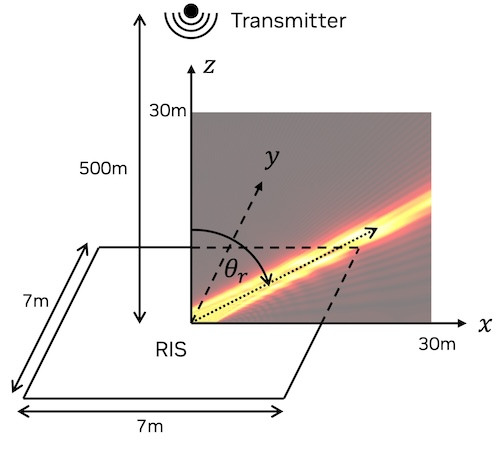

The first steps consists in setting up the scene:

In [3]:
# Load an empty scene and configure single linearly polarized antennas for
# all transmitters and receivers
scene = load_scene()
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter far away from the RIS so that
# the incoming wave is almost planar
tx = Transmitter("tx", [0,0,500])
scene.add(tx)

# Configure RIS in the x-z plane centered at the origin
width = 7 # Width [m] as described in [1]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[0,0,0],
          orientation=[0,-PI/2,0],
          num_rows=num_rows,
          num_cols=num_cols)
scene.add(ris)

In the cell above, we have configured an RIS such that it closely matches the desired dimensions.
However, because of the discrete $\lambda/2$ spacing of of unit cells, this can only be approximately achieved.
We can inspect some of the RIS' properties as follows:

In [4]:
print("RIS size (width, height) [m]: ", ris.size.numpy())
print("Number of cells: ", ris.num_cells)
print("Velocity vector [m/s]: ", ris.velocity.numpy())

RIS size (width, height) [m]:  [6.9951572 6.9951572]
Number of cells:  19600
Velocity vector [m/s]:  [0. 0. 0.]


Like any scene object in Sionna RT, RIS can have a velocity vector which is used to compute path-specific Doppler shifts. We will not make use of this property in this tutorial. You can learn more about mobility in Sionna in this [notebook](https://nvlabs.github.io/sionna/examples/Sionna_Ray_Tracing_Mobility.html).

RIS have a [phase profile](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.PhaseProfile) and an [amplitude profile](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.AmplitdueProfile) which default to a configuration where the RIS acts like a normal mirror-like reflector.

In [5]:
print(ris.phase_profile)
print(ris.amplitude_profile)

Each profile is defined by a tensor of shape `[num_modes, num_rows, num_cols]` containing either amplitude or phase values [rad] for every reradiation mode.
Let us inspect the default values of these tensors.

In [6]:
print(ris.amplitude_profile.values)
print(ris.phase_profile.values)

tf.Tensor(
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]], shape=(1, 140, 140), dtype=float32)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 140, 140), dtype=float32)


We can see that the RIS has a single reradiation mode, the amplitudes are equal to one and the phases equal to zero.

An RIS is defined in the y-z plane, centered at the origin, and assumed to point toward the positive x-axis.

A rapid way to configure the amplitude and phase profiles is via the helper functions [RIS.focusing_lens()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.RIS.focusing_lens) or [RIS.phase_gradient_reflector()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.RIS.phase_gradient_reflector). However, any other configuration is possible by simply assigning the desired profile values. All of these options will be explored later on.

Let us now inspect the phase profile differences between a focusing lens and a phase gradient reflector. Both assume that a wave arrives from a certain point or direction, i.e., a `source`, and some of its energy shall be reradiated toward another point or direction, i.e., a `target`. 
Multiple reradiation modes can be configured by providing pairs of sources and targets. This is also further explored below.

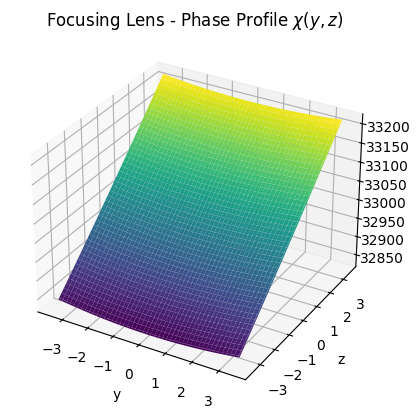

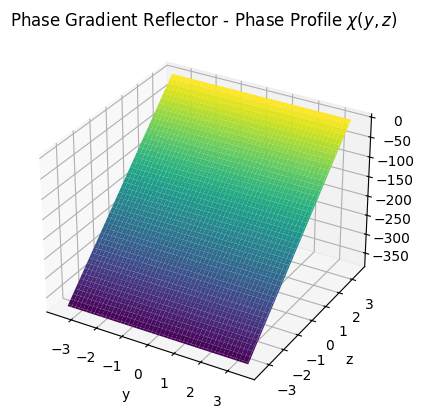

In [7]:
source = tx.position # Location of the origin of the incoming ray
target = 25.*r_hat(PI/3, 0.) # Target position

# Configure the RIS as focusing lens
ris.focusing_lens(source, target)

# Visualize the phase profile
ris.phase_profile.show();
plt.title(r"Focusing Lens - Phase Profile $\chi(y,z)$");

# Configure the RIS as phase gradient reflector
# Source and target vectors are automatically nornmalized
# in this function as only the directions matter
ris.phase_gradient_reflector(source, target)

# Visualize the phase profile
ris.phase_profile.show();
plt.title(r"Phase Gradient Reflector - Phase Profile $\chi(y,z)$");

One can see from the visualization above that the phase profile of the focusing lens is designed such that it achieves perfect constructive interference at the desired target point, while the phase gradient reflector has a linearly decreasing phase in the z coordinate.
In world coordinates, this corresponds to a constant phase gradient in the x-direction.

Note that phases are not wrapped to the $[0, \pi)$ intervall. The reason for this is that the computation of the phase gradient along an RIS requires continuously evolving phase values.

With our scene set up and the RIS configured as phase gradient reflector, we can now compute the electric field at the desired positions.

Note: As a small experiment, you can configure the RIS again as focusing lens and observe the differences in the simulations below.

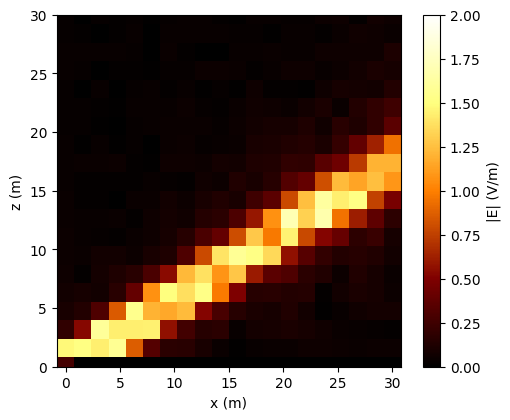

In [8]:
# ris.focusing_lens(source, target) # Uncomment to change the RIS configuration

# Define a grid of points in the x-z plane
x_min = 0
x_max = 30
num_steps = 20 # Increase to obtain a finer resolution
x = tf.cast(tf.linspace(x_min, x_max, num_steps), tf.float32)
x_grid, z_grid = tf.meshgrid(x, x)
x = tf.reshape(x_grid, [-1])
z = tf.reshape(z_grid, [-1])
y = tf.zeros_like(x)
r = tf.stack([x, y, z], -1)

def field_at_points(scene, r, batch_size, path_loss=False):
    """
    Compute absolute field strength at a list of positions

    Input
    -----
    r : [num_points, 3]
        Points at which the field should be computed

    batch_size : int
        Since we cannot compute the field at all points
        simultaneously, we need to batch the computations.
        Must divide `num_points` without rest.

    path_loss : bool
        If `True`, the path loss in dB is returned and not the
        absolte field strength.

    Output
    ------
    e : [num_points]
        Absolute value of field strength
    """
    # Add batch_size receivers to the scene
    # if they do not already exist
    if len(scene.receivers)==0:
        for i in range(batch_size):
            scene.add(Receiver(f"rx-{i}", [0,0,0]))

    # Iteratively compute field for all positions
    r_vec = tf.reshape(r, [-1, batch_size, 3])
    em = tf.zeros([0], tf.float32)
    for j, rs in enumerate(r_vec):
        
        # Move receivers to new positions
        for i,r in enumerate(rs):
            scene.get(f"rx-{i}").position=r
        
        # Compute paths and obtain channel impulse responses
        paths = scene.compute_paths(los=False, reflection=False, ris=True)
        a = tf.squeeze(paths.cir()[0])
        
        # We need to scale the path gain by the distance from the 
        # transmitter to the RIS to simulate an incoming field stength of
        # 1 V/m and undo the effect of the isotropic antenna
        # see https://nvlabs.github.io/sionna/em_primer.html#equation-h-final
        if path_loss:
            e = 20*tf.math.log(tf.abs(a))/tf.math.log(10.)
        else:    
            e = 4*PI/scene.wavelength*normalize(tx.position)[1]*tf.abs(a)
        em = tf.concat([em, e], axis=0)
    return em

em = field_at_points(scene, r, 40)
em = tf.reshape(em, x_grid.shape)

# Visualize the field
plt.figure(figsize=(5.55, 4.57))
plt.pcolormesh(x_grid, z_grid, em, cmap='afmhot', vmin=0, vmax=2)
plt.ylim([0, 30])
cb = plt.colorbar()  
cb.set_label(r"|E| (V/m)")
plt.xlabel("x (m)");
plt.ylabel("z (m)");

You can run the cell above with a larger value of `num_steps` to improve the resolution. As this might take some time, we provide the result for 500 steps below:

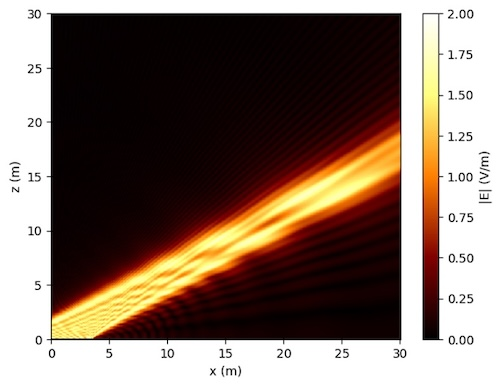

This is to be compared against Fig. 4 from [[1]](#References):

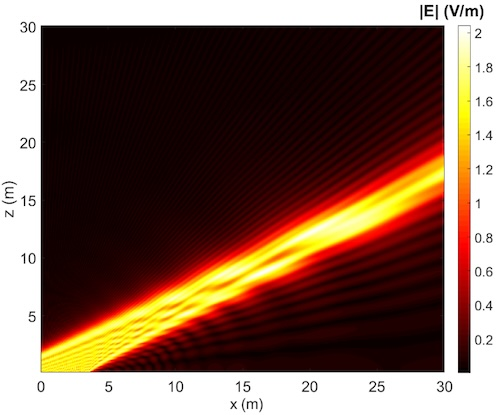

## RIS with Multiple Reradiation Modes

An RIS can be configured to have mutiple reradiation modes.
The following code visualizes the path loss in the horizontal plane (z=5m) for an RIS that steers energy toward two different directions. The power of each reradiation mode can be configured.
Otherwise the setup is identicial to the previous example with the unique difference that the transmitter is located much closer to the RIS, i.e., z=50m.

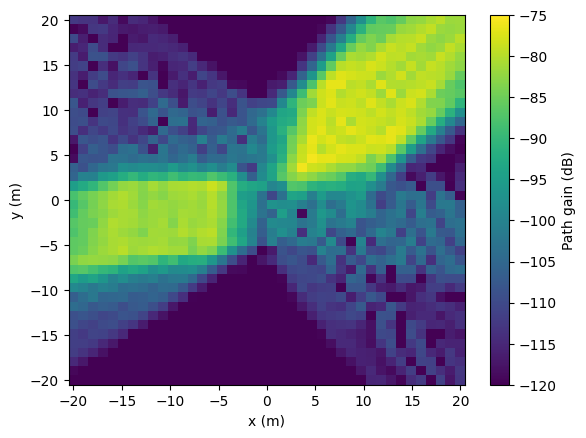

In [9]:
# Load empty scene
scene = load_scene()
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter 
tx = Transmitter("tx", [0,0,50])
scene.add(tx)

# Configure RIS in the x-z plane centered at the origin
# Note that we need to configure `num_modes=2` here.
width = 7 # Width [m]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
              position=[0,0,0],
              orientation=[0,-PI/2,0],
              num_rows=num_rows,
              num_cols=num_cols,
              num_modes=2)
scene.add(ris)

# Configure the RIS with two reradiation modes
# Each reradiation mode is defined by a pair of source and target vectors
z_target = 5
sources = [tx.position, tx.position]
targets = [[10, 10, z_target], [-10, -2, z_target]]
ris.phase_gradient_reflector(sources, targets)

# Uncomment to observe the difference when a focusing lens is used.
# ris.focusing_lens(sources, targets) 

# You can freely distribute power among the modes
ris.amplitude_profile.mode_powers = [0.7, 0.3]

# Define a grid of points in the x-y plane at some height
x_min = -20
x_max = 20
num_steps = 40 # Increase to obtain a finer resolution
x = tf.cast(tf.linspace(x_min, x_max, num_steps), tf.float32)
x_grid, y_grid = tf.meshgrid(x, x)
x = tf.reshape(x_grid, [-1])
y = tf.reshape(y_grid, [-1])
z = z_target*tf.ones_like(x)
r = tf.stack([x, y, z], -1)

# Compute path loss
pl = field_at_points(scene, r, 40, path_loss=True)
pl = tf.reshape(pl, x_grid.shape)

# Visualize the field
plt.figure()
plt.pcolormesh(x_grid, y_grid, pl, vmax=-75, vmin=-120)
cb = plt.colorbar()  
cb.set_label(r"Path gain (dB)")
plt.xlabel("x (m)");
plt.ylabel("y (m)");

For comparison, let us have a look at the coverage map:

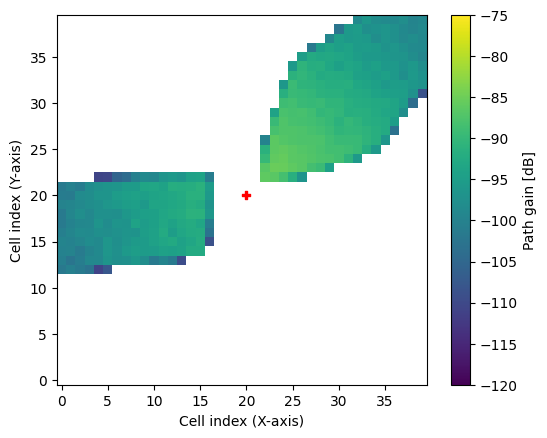

In [10]:
cm = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10e6,
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,z_target],
                        cm_size=[40,40],
                        cm_cell_size=[1, 1])
cm.show(vmin=-120, vmax=-75);

While the zones of coverage match closely the ones we have computed via [scene.compute_paths()](https://nvlabs.github.io/sionna/api/rt.html#compute-paths) for individually placed receiver locations, we can see that large areas of the coverage map are empty. The reasons for this are (i) that anomalous diffraction around the RIS' edges as described in Section II-C [[2]](#References) is not modelled and (ii) that the coverage map is located very close to the RIS, i.e., around 5m. The difference between both results becomes smaller in the far field.

Also note that the line-of-sight field components are not taken into account here for a better visualization. The latter would be the dominating source of radiation otherwise. 

## Coverage Enhancement with RIS

In the next example, we will use an RIS to improve the coverage in a certain area of a scene.
The code below should by now be easy to follow without additional explanations.

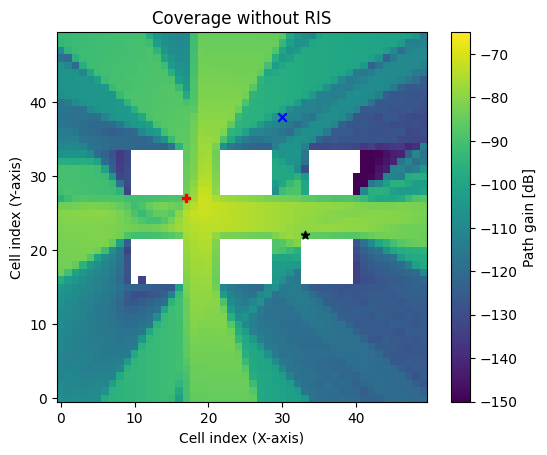

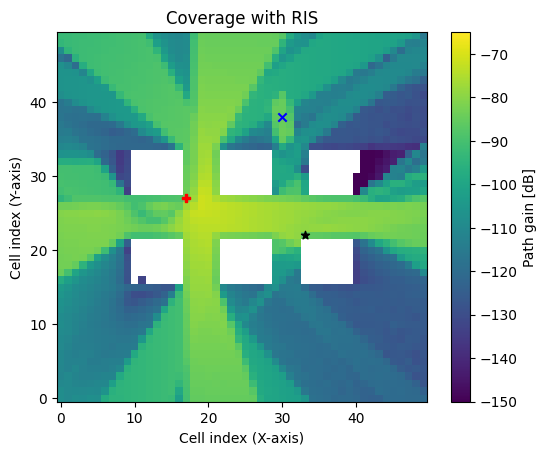

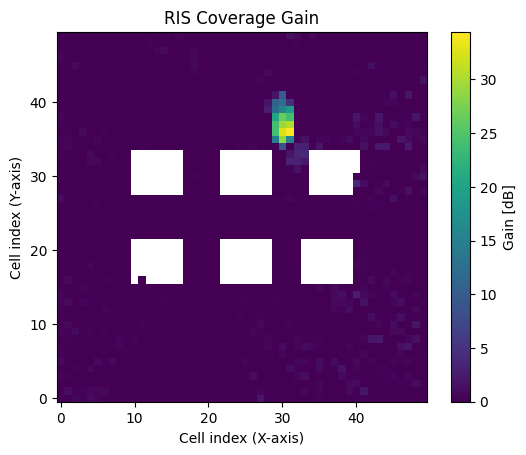

In [11]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter 
tx = Transmitter("tx", position=[-32,10,32], look_at=[0,0,0])
scene.add(tx)

# Place a receiver (we will not actually use it
# for anything apart from referencing the position)
rx = Receiver("rx", position=[22,52,1.7])
scene.add(rx)

# Place RIS
ris = RIS(name="ris",
          position=[32,-9,32],
          num_rows=100,
          num_cols=100,
          num_modes=1,
          look_at=(tx.position+rx.position)/2) # Look in between TX and RX
scene.add(ris)

# Configure RIS as phase gradient reflector that reradiates energy
# toward the direction of the receivers
ris.phase_gradient_reflector(tx.position, rx.position)

# Compute coverage map without RIS
cm_no_ris = scene.coverage_map(num_samples=10e6,
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=False,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_no_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True);
plt.title("Coverage without RIS");

# Compute coverage map with RIS
cm_ris = scene.coverage_map(num_samples=10e6,
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=True,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True);
plt.title("Coverage with RIS");

# Visualize the coverage improvements thanks to the RIS
fig = plt.figure()
plt.imshow(10*np.log10(cm_ris._value[0]/cm_no_ris._value[0]), origin='lower', vmin=0)
plt.colorbar(label='Gain [dB]')
plt.xlabel('Cell index (X-axis)');
plt.ylabel('Cell index (Y-axis)');
plt.title("RIS Coverage Gain");

As expected, the coverage has significantly improved in a small area around the receiver. We can also visualize the coverage map together with the RIS as follows:

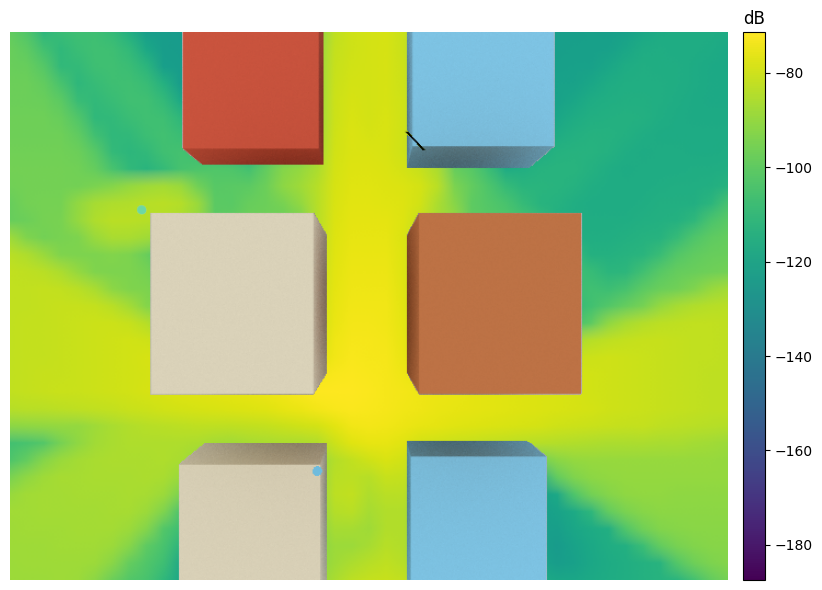

In [12]:
# Open 3D preview (only works in Jupyter notebook)
if colab_compat:
    if scene.get("birds-eye") is None:
        scene.add(Camera("birds-eye",
                         position=[0,0,200],
                         look_at=[0,0,0]))
    scene.render(camera="birds-eye",
                 num_samples=512,
                 coverage_map=cm_ris);
    raise ExitCell
scene.preview(coverage_map=cm_ris,
              show_orientations=True)

## Gradient-Based RIS Optimization

In the previous example, we have configured the RIS's phase profile by hand. Sionna RT offers also the possibility to optimize phase and amplitude profiles via gradient descent.

We will now jointly optimize various RIS parameters, namely the phase and amplitude profiles, as well as the power allocation of reradiation modes. The optimization goal is to maximize the average received signal strength at two receivers which are served by a single transmitter with the help of two RIS. The scene is setup in such a way that both receivers are only reachable from the transmitter via the RIS.

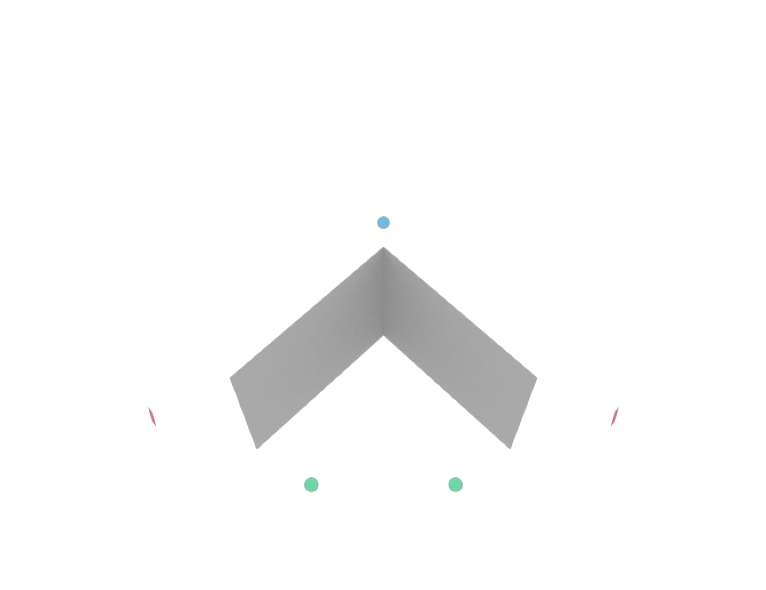

In [13]:
# Load scene consiting of a simple wedge
scene = load_scene(sionna.rt.scene.simple_wedge)
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter 
tx = Transmitter("tx", position=[-10,10,0])
scene.add(tx)

# Place receivers
rx1 = Receiver("rx1", position=[30,-15,0])
scene.add(rx1)
rx2 = Receiver("rx2", position=[15,-30,0])
scene.add(rx2)

# Place RIS
ris1 = RIS(name="ris1",
          position=[40,10,0],
          num_rows=50,
          num_cols=50,
          num_modes=2,
          look_at=(tx.position+rx1.position)/2) # Look in between TX and RX1
scene.add(ris1)

ris2 = RIS(name="ris2",
          position=[-10,-40,0],
          num_rows=50,
          num_cols=50,
          num_modes=2,
          look_at=(tx.position+rx2.position)/2) # Look in between TX and RX2
scene.add(ris2)

# Visualize scene
if colab_compat:
    if scene.get("cam") is None:
        scene.add(Camera("cam",
                         position=[50,-50,130],
                         look_at=[0,0,0]))
    scene.render(camera="cam", num_samples=512);
    raise ExitCell
    
scene.preview(show_orientations=True)

We will now configure the parameters of interest as trainable variables which can be optimized via gradient-descent.

In [14]:
# Make the phase profile trainable
# Initialize all phases to zero
ris1.phase_profile.values = tf.Variable(tf.zeros_like(ris1.phase_profile.values))
ris2.phase_profile.values = tf.Variable(tf.zeros_like(ris2.phase_profile.values))

# Create trainable variables for the amplitude profile
# to which some normalization will be applied in the training loop.
# Initialize all values to one and ensure that the gradient update can
# never make the values negative.
a1 = tf.Variable(tf.ones_like(ris1.amplitude_profile.values),
                 constraint=lambda x: tf.abs(x))
a2 = tf.Variable(tf.ones_like(ris2.amplitude_profile.values),
                 constraint=lambda x: tf.abs(x))

# Make mode powers trainable
# to which some normalization will be applied in the training loop.
# We cannot set them to zero as the gradient is infinitely large at this point.
# Ensure that gradient updates can never bring the mode powers
# out of their desired range.
m1 = tf.Variable([0.99, 0.01], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))
m2 = tf.Variable([0.99, 0.01], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))

Next, we will setup a gradient-based optimization step that can be iterated until convergence.

In [15]:
# Define an optimizer
optimizer = tf.keras.optimizers.Adam(0.5)

# Helper function to compute dB
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)

# Define a training step
def train_step():
    with tf.GradientTape() as tape:

        # Set amplitude profile values while ensuring an average power of one
        ris1.amplitude_profile.values = a1/tf.sqrt(tf.reduce_mean(a1**2, axis=[1,2], keepdims=True))
        ris2.amplitude_profile.values = a2/tf.sqrt(tf.reduce_mean(a2**2, axis=[1,2], keepdims=True))

        # Set mode powers while ensuring a total power of one
        ris1.amplitude_profile.mode_powers = m1/tf.reduce_sum(m1)
        ris2.amplitude_profile.mode_powers = m2/tf.reduce_sum(m2)
        
        # Compute paths
        paths = scene.compute_paths()

        # Convert to baseband-equivalent channel impulse response
        # Get rid of all unused dimensions
        # [num_rx=2, num_tx=2]
        a = tf.squeeze(paths.cir()[0])
        
        # Compute average paths gain per RX
        path_gain = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1)))
        loss = -path_gain
    
    # Compute gradients with the goal of maximizing the path gain
    grads = tape.gradient(loss, tape.watched_variables())
    # Apply optimizer
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
   
    return path_gain, a

We are now ready to exectue our training loop:

In [16]:
# Create a storage tensor for intermediate results
a_it = tf.zeros([0, 2, 2], dtype=tf.complex64)

# Run training iterations
num_iterations = 100
for i in range(num_iterations):
    path_gain, a = train_step()
    a_it = tf.concat([a_it, a[tf.newaxis]], axis=0)
    if i%10==0 or i==0:
        print(f"Iteration {i} - Path gain: {path_gain.numpy():.2f}dB")        

Iteration 0 - Path gain: -101.99dB
Iteration 10 - Path gain: -72.36dB
Iteration 20 - Path gain: -70.63dB
Iteration 30 - Path gain: -69.55dB
Iteration 40 - Path gain: -69.03dB
Iteration 50 - Path gain: -68.75dB
Iteration 60 - Path gain: -68.58dB
Iteration 70 - Path gain: -68.45dB
Iteration 80 - Path gain: -68.35dB
Iteration 90 - Path gain: -68.26dB


Let's have a look at the learned phase and amplitude profiles.:

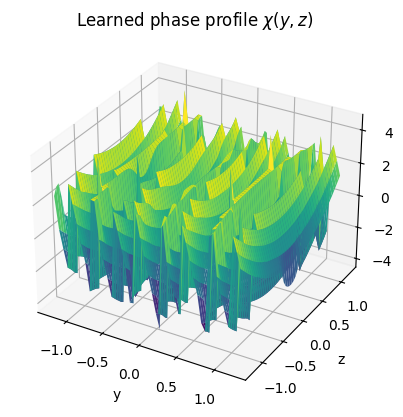

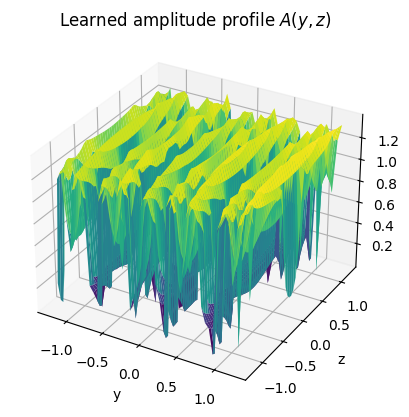

In [17]:
ris1.phase_profile.show(0);
plt.title(r"Learned phase profile $\chi(y,z)$");
ris1.amplitude_profile.show(0);
plt.title(r"Learned amplitude profile $A(y,z)$");

Note that the learned phase and amplitude profiles might not necessarily be realizable by an RIS.
Other forms of regularization could be used to constrain the space of allowed values.

For performance comparison, we also evaluate both RIS configured as focusing lenses towards both receivers:

Path gain with focusing lens: -71.74dB


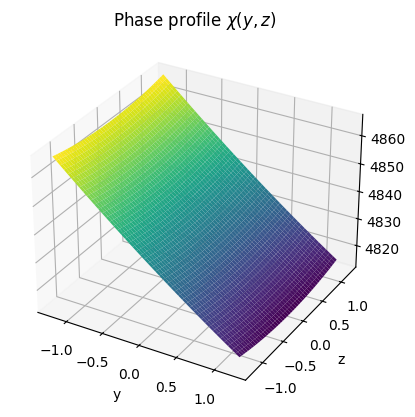

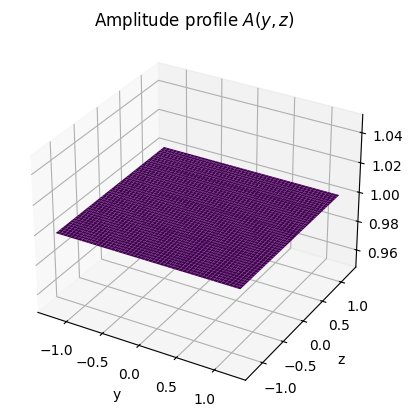

In [18]:
# Configure both RIS as focusing lenses
ris1.focusing_lens([tx.position, tx.position], [rx1.position, rx2.position])
ris2.focusing_lens([tx.position, tx.position], [rx1.position, rx2.position])

# Compute paths and average path gain
paths_lens = scene.compute_paths()
a_lens = tf.squeeze(paths_lens.cir()[0])
path_gain_lens = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a_lens)**2, axis=-1)))
print(f"Path gain with focusing lens: {path_gain_lens.numpy():.2f}dB")

# Visualize phase and amplitude profile for one reradiation mode
ris1.phase_profile.show(mode=0);
ris1.amplitude_profile.show(mode=0);

We can now compare the path gain behaviour of the learned and deterministic RIS configurations in more detail:

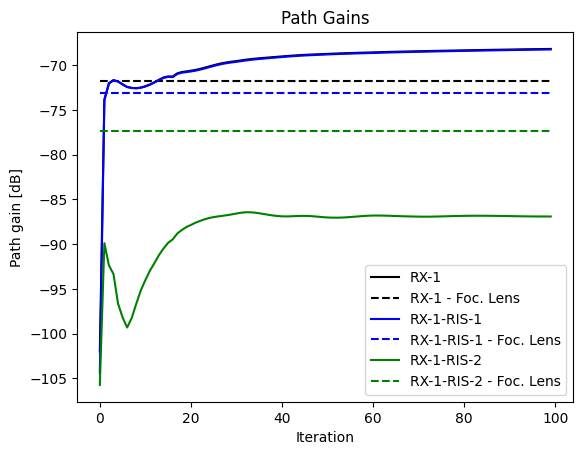

In [19]:
# Compute path gains for each paths
rx_ris_path_gain = tf.abs(a_it)**2
rx_ris_path_gain_lens = tf.abs(a_lens)**2

# Path gains per receiver
rx_path_gain = tf.reduce_sum(rx_ris_path_gain, axis=-1)
rx_path_gain_lens = tf.reduce_sum(rx_ris_path_gain_lens, axis=-1)

plt.figure()

plt.plot(to_db(rx_path_gain[:,0]), "k", label="RX-1")
plt.plot([to_db(rx_path_gain_lens[0])]*num_iterations, "--k", label="RX-1 - Foc. Lens")

plt.plot(to_db(rx_ris_path_gain[:,0,0]), "b", label="RX-1-RIS-1")
plt.plot([to_db(rx_ris_path_gain_lens[0,0])]*num_iterations, "--b", label="RX-1-RIS-1 - Foc. Lens")

plt.plot(to_db(rx_ris_path_gain[:,0,1]), "g", label="RX-1-RIS-2")
plt.plot([to_db(rx_ris_path_gain_lens[0,1])]*num_iterations, "--g", label="RX-1-RIS-2 - Foc. Lens")

plt.legend()
plt.xlabel("Iteration");
plt.ylabel("Path gain [dB]");
plt.title("Path Gains");

In this scenario, the learned RIS configuration amplifies the link to the closest RX at the cost of a weaker link to the other RX to obtain an overall path gain.
"RX-1" denotes the overal path gain for the first receiver, while "RX-1-RIS-1" and "RX-1-RIS2" denote the path gains for the individual links between the first receiver and the first and second RIS, respectively.

The results for the second receiver look identical due to the symmetry of the setup.

## Summary

In this notebook, you have learned how to configure, use, and optimize reconfigurable intelligent surfaces (RIS) in Sionna RT.
It is important to keep in mind that not all RIS configurations, such as the ones showed above, are realizable in practice.

RIS modeling and optimization are fields of active research and the examples in this notebook are only meant to help you get started.

We hope you enjoyed this tutorial and encourage you to get hands-on, conduct your own experiments, and deepen your understanding of ray tracing. There’s always more to learn, so do explore our other [tutorials](https://nvlabs.github.io/sionna/tutorials.html#ray-tracing) as well.

## References

[1] Vittorio Degli-Esposti et al., [Reradiation and Scattering From a Reconfigurable Intelligent Surface: A General Macroscopic Model](https://ieeexplore.ieee.org/abstract/document/9713744), IEEE Trans. Antennas Propag, vol. 70, no. 10,  pp.8691-8706, Oct. 2022.

[2] Enrico Maria Vittuci et al., [An Efficient Ray-Based Modeling Approach for Scattering From Reconfigurable Intelligent Surfaces](https://ieeexplore.ieee.org/abstract/document/10419169), IEEE Trans. Antennas Propag, vol. 72, no. 3,  pp.2673-2685, Mar. 2024.